# Trabajo Práctico 4
*   Arelis Picado
*   Diego Solís
*   Isaac Vargas

### Librerías

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. **(80 puntos)** Algoritmo de Maximización de la Esperanza con datos artificiales (modelo Gaussiano)


A continuación, implemente el algoritmo de maximización de la esperanza (descrito en el material del curso), usando la definición y descripción de las siguientes funciones como base:

##### 1.   **(15 puntos)** Implemente la función generate_data, la cual reciba la cantidad de observaciones unidimensionales total a generar N, y los parámetros correspondientes a $K=2$ funciones de densidad Gaussianas. Genere los datos siguiendo tales distribuciones, y retorne tal matriz de datos $X\in\mathbb{R}^{N\times1}$.

a) Grafique los datos usando un scatter plot junto con las gráficas de los histogramas de los datos y las funciones de densidad de probabilidad Gaussianas usando los parámetros para inicializar los datos, en la misma figura (gráfico). Escoja 3 conjuntos de parámetros para mostrar los 3 datasets resultantes.

In [2]:
def generate_data(N, mu1, sigma1, mu2, sigma2, pi1=0.5, pi2=0.5):
    """
    Generates data following a mixture of two Gaussian distributions.

    Parameters:
    - N: Total number of observations to generate.
    - mu1, sigma1: Mean and standard deviation for the first Gaussian.
    - mu2, sigma2: Mean and standard deviation for the second Gaussian.
    - pi1, pi2: Weights (membership probabilities) for each Gaussian distribution.

    Returns:
    - X: Generated data matrix of size (N, 1).
    """
    # Generate labels for each sample according to probabilities pi1 and pi2
    labels = np.random.choice([0, 1], size=N, p=[pi1, pi2])

    # Generate data for each label according to the corresponding Gaussian
    X = np.zeros(N)
    X[labels == 0] = np.random.normal(mu1, sigma1, size=(labels == 0).sum())
    X[labels == 1] = np.random.normal(mu2, sigma2, size=(labels == 1).sum())

    return X.reshape(-1, 1)  # Return as a column vector

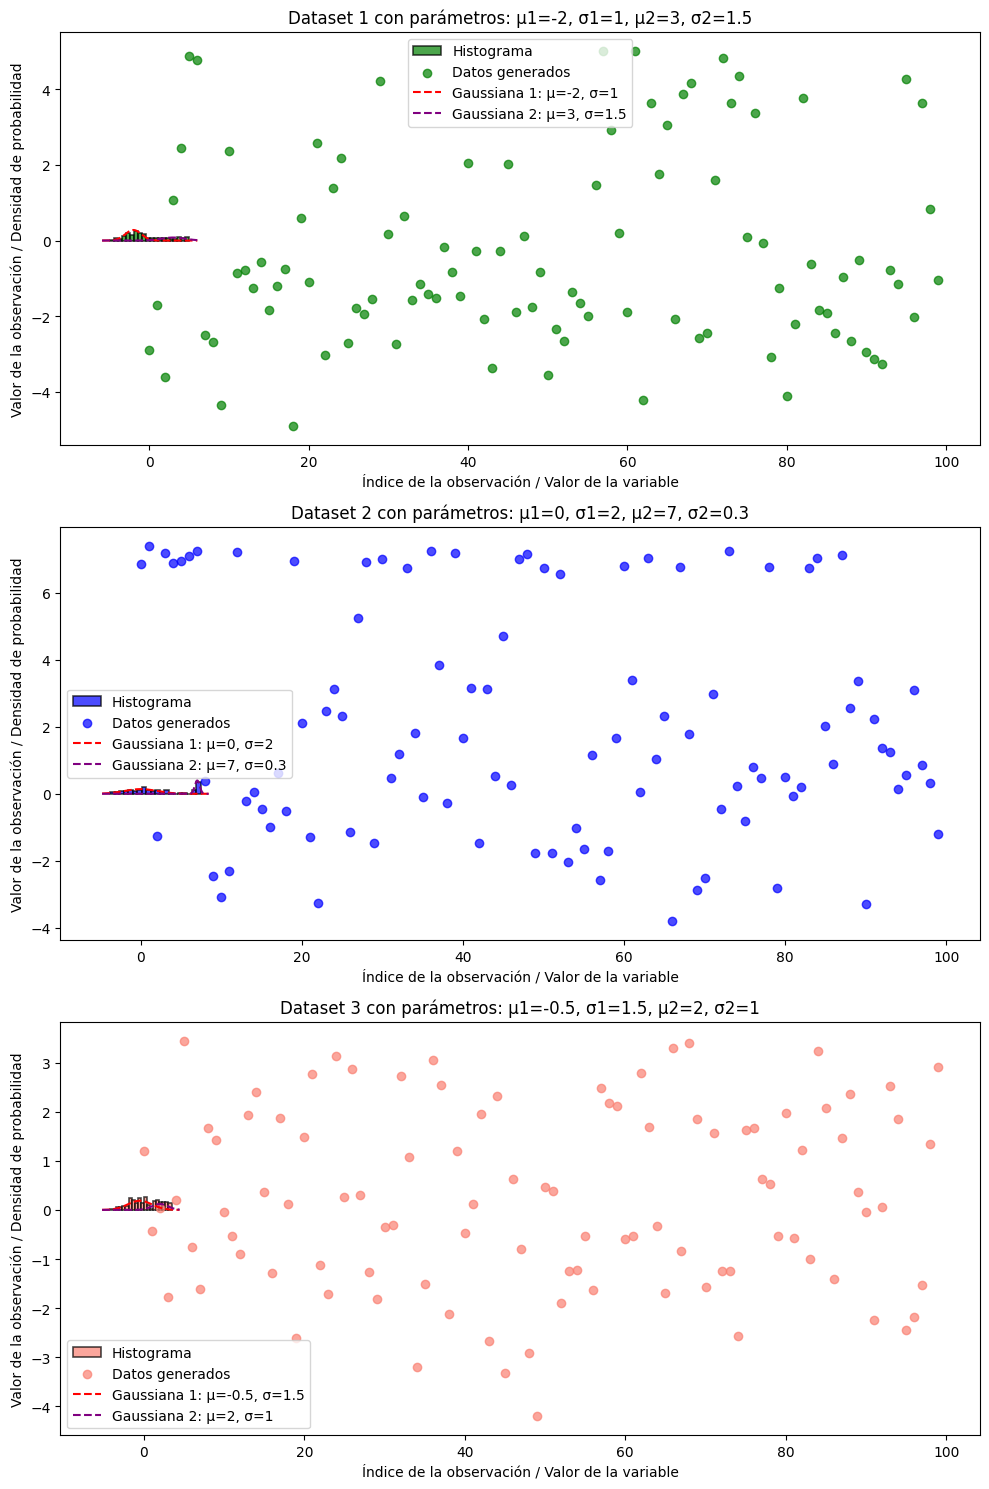

In [3]:
# Data parameters
parameters = [
    (100, -2, 1, 3, 1.5),
    (100, 0, 2, 7, 0.3),
    (100, -0.5, 1.5, 2, 1)
]

# Color for dataset
colors = ['green', 'blue', 'salmon']

fig, axs = plt.subplots(3, 1, figsize=(10, 15))
for i, (N, mu1, sigma1, mu2, sigma2) in enumerate(parameters):
    pi1, pi2 = 0.7, 0.3  # Probabilidades de mezcla

    # Scatter plot and histogram
    X = generate_data(N, mu1, sigma1, mu2, sigma2, pi1=pi1, pi2=pi2)
    axs[i].hist(X, bins=20, density=True, alpha=0.7, color=colors[i], label="Histograma", edgecolor='black', linewidth=1.2)
    axs[i].scatter(np.arange(N), X, color=colors[i], alpha=0.7, label="Datos generados")

    # Probability density functions
    x_vals = np.linspace(X.min() - 1, X.max() + 1, 500)
    pdf1 = norm.pdf(x_vals, mu1, sigma1) * pi1
    pdf2 = norm.pdf(x_vals, mu2, sigma2) * pi2
    axs[i].plot(x_vals, pdf1, color='red', linestyle='--', label=f"Gaussiana 1: μ={mu1}, σ={sigma1}")
    axs[i].plot(x_vals, pdf2, color='purple', linestyle='--', label=f"Gaussiana 2: μ={mu2}, σ={sigma2}")

    axs[i].set_title(f"Dataset {i+1} con parámetros: μ1={mu1}, σ1={sigma1}, μ2={mu2}, σ2={sigma2}")
    axs[i].set_xlabel("Índice de la observación / Valor de la variable")
    axs[i].set_ylabel("Valor de la observación / Densidad de probabilidad")
    axs[i].legend()

plt.tight_layout()
plt.show()

##### 2.   **(5 puntos)** Implemente la función init_random_parameters la cual genere una matriz de $P\in\mathbb{R}^{K\times2}$ dimensiones, con los parámetros de las funciones de densidad Gaussiana generados completamente al azar.

a) Muestre un pantallazo donde verifique su funcionamiento correcto con los comentarios asociados.

In [4]:
def init_random_parameters(K=2):
    """
    Initializes random parameters for K Gaussian distributions.

    Returns:
    - P (numpy array): Matrix of dimensions (K, 2) where each row represents
      (mean, standard deviation) for each Gaussian distribution.
    """
    # Generate K random means and standard deviations
    # mu (mean) is generated between -10 and 10
    # sigma (standard deviation) is ensured to be positive (between 0.1 and 5)
    mu = np.random.uniform(-10, 10, size=K)
    sigma = np.random.uniform(0.1, 5, size=K)

    # Combine into a matrix of dimensions (K, 2)
    P = np.column_stack((mu, sigma))

    return P

In [5]:
# Random
for i in range(3):
    P = init_random_parameters(K=2)
    print(f"Matriz de parámetros aleatorios P (Ejemplo {i+1}):\n", P, "\n")

Matriz de parámetros aleatorios P (Ejemplo 1):
 [[4.8254257  0.96417511]
 [4.57990669 1.66114678]] 

Matriz de parámetros aleatorios P (Ejemplo 2):
 [[-2.55080821  1.25389717]
 [-1.06936137  3.82298019]] 

Matriz de parámetros aleatorios P (Ejemplo 3):
 [[ 8.38460732  3.95829773]
 [-6.18669865  3.2203414 ]] 



##### 3.   **(20 puntos)** Implemente la función calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k) la cual calcule la verosimilitud de una observación específica $x_{n}$, para una función de densidad Gaussiana con parámetros $\mu_{k}$ y $\sigma_{k}$. Realice la corrección pertinente al cálculo de la función de verosimilitud para evitar el problema de under flow.

a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados.

In [6]:
def calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k):
    """
    Calculates the likelihood of a specific observation x_n for a Gaussian 
    distribution with mean mu_k and standard deviation sigma_k.
    The logarithm of the probability density is used to avoid underflow.
    
    Parameters:
    - x_n: Value of the observation.
    - mu_k: Mean of the Gaussian distribution.
    - sigma_k: Standard deviation of the Gaussian distribution.
    
    Returns:
    - The likelihood of x_n under the Gaussian distribution with mean mu_k and sigma_k as a scalar.
    """
    # Ensure inputs are scalar tensors
    if not isinstance(x_n, torch.Tensor):
        x_n = torch.tensor(x_n, dtype=torch.float32)
    if not isinstance(mu_k, torch.Tensor):
        mu_k = torch.tensor(mu_k, dtype=torch.float32)
    if not isinstance(sigma_k, torch.Tensor):
        sigma_k = torch.tensor(sigma_k, dtype=torch.float32)

    # Ensure the tensors are scalar by squeezing them
    x_n = x_n.squeeze()
    mu_k = mu_k.squeeze()
    sigma_k = sigma_k.squeeze()

    # Add a small epsilon to sigma to avoid division by zero
    epsilon = 1e-6
    sigma_k = torch.clamp(sigma_k, min=epsilon)
    
    # Calculate the logarithm of the Gaussian probability density
    log_likelihood = -0.5 * torch.log(2 * torch.pi * sigma_k ** 2) - ((x_n - mu_k) ** 2) / (2 * sigma_k ** 2)

    # Debugging: print shapes and values to check for NaNs or Inf values
    print(f"x_n: {x_n}, mu_k: {mu_k}, sigma_k: {sigma_k}")
    print(f"log_likelihood: {log_likelihood}")

    # If log_likelihood contains NaNs, handle by returning a very low likelihood
    if torch.any(torch.isnan(log_likelihood)):
        return 1e-10  # return a very low likelihood value to avoid NaNs

    # Convert from log-likelihood to likelihood and return as scalar
    likelihood = torch.exp(log_likelihood).item()  # Use .item() to return a scalar float
    return likelihood


In [7]:
def unitTest_calculate_likelihood_gaussian_observation():
    """
    Unit test for the function calculate_likelihood_gaussian_observation.
    Verifies that the function correctly computes the likelihood for a given observation.
    """
    # Test parameters
    x_n = 0
    mu_k = 0
    sigma_k = 1

    # Expected likelihood calculation using the Gaussian density formula
    expected_likelihood = (1 / (np.sqrt(2 * np.pi) * sigma_k)) * np.exp(-0.5 * ((x_n - mu_k) / sigma_k) ** 2)

    # Calculate likelihood using the function
    calculated_likelihood = calculate_likelihood_gaussian_observation(x_n, mu_k, sigma_k)

    # Check if the calculated value is approximately equal to the expected value
    assert np.isclose(calculated_likelihood, expected_likelihood, atol=1e-9), \
        f"Test failed: calculated likelihood is {calculated_likelihood}, expected {expected_likelihood}"

    print("Test passed: Calculated likelihood matches the expected value.")

# Run the unit test
unitTest_calculate_likelihood_gaussian_observation()

x_n: 0.0, mu_k: 0.0, sigma_k: 1.0
log_likelihood: -0.9189385175704956
Test passed: Calculated likelihood matches the expected value.


##### 4.   **(10 puntos)** Implemente la función calculate_membership_dataset(X_dataset, Parameters_matrix), la cual, usando la matriz de parámetros P y la función anteriormente implementada calculate_likelihood_gaussian_observation, defina por cada observación $x_{n}\in X$ la pertenencia o membresía a cada cluster $k=1$,$\ldots K$, en una matriz binaria $M\in\mathbb{R}^{N\times K}$. Retorne tal matriz de membresía M.

a) Diseñe y ejecute una prueba unitaria donde verifique su funcionamiento correcto con los comentarios asociados.

In [8]:
def calculate_membership_dataset(X_dataset, Parameters_matrix):
    """
    Calculates the membership matrix for a dataset based on Gaussian parameters.

    Parameters:
    - X_dataset: Tensor of shape (N, 1), where N is the number of observations.
    - Parameters_matrix: Tensor of shape (K, 2), where each row represents (mean, std) for each Gaussian.

    Returns:
    - M: Binary membership matrix of shape (N, K), where each entry is 1 if the observation belongs to the cluster with the highest likelihood.
    """
    # Debugging: Print the shape of Parameters_matrix
    print(f"Parameters_matrix shape: {Parameters_matrix.shape}")
    
    N = X_dataset.shape[0]
    K = Parameters_matrix.shape[0]

    # Ensure Parameters_matrix has the correct shape
    if Parameters_matrix.shape[1] != 2:
        raise ValueError("Parameters_matrix should have shape (K, 2)")

    # Initialize the membership matrix with zeros
    M = torch.zeros((N, K), dtype=torch.float32)
    
    for i in range(N):
        x_n = X_dataset[i, 0]

        # Calculate likelihoods for each Gaussian and store them in a list
        likelihoods = [
            calculate_likelihood_gaussian_observation(
                x_n,
                Parameters_matrix[k, 0].item(),  # Extract scalar mean for Gaussian k
                Parameters_matrix[k, 1].item()   # Extract scalar std for Gaussian k
            )
            for k in range(K)
        ]

        # Convert likelihoods to a tensor for easier handling with PyTorch functions
        likelihoods = torch.tensor(likelihoods, dtype=torch.float32)

        # Find the index of the Gaussian with the highest likelihood
        max_likelihood_index = torch.argmax(likelihoods)

        # Assign membership to the cluster with the highest likelihood
        M[i, max_likelihood_index] = 1

    return M






In [9]:
def unitTest_calculate_membership_dataset():
    """
    Unit test for the function calculate_membership_dataset.
    Verifies that the function correctly computes the membership matrix for a given dataset.
    """
    # Test dataset
    X_test = np.array([[1.0], [4.0], [7.0]])
    
    # Test parameters (2 Gaussians with different means)
    P_test = np.array([
        [2.0, 1.0],  # Gaussian 1 with mean 2 and standard deviation 1
        [6.0, 1.0]   # Gaussian 2 with mean 6 and standard deviation 1
    ])
    
    # Expected membership matrix based on likelihoods
    expected_M = np.array([
        [1, 0],  # Closer to Gaussian 1
        [1, 0],  # Tied likelihoods, assigned to Gaussian 1
        [0, 1]   # Closer to Gaussian 2
    ])
    
    # Calculate membership matrix using the function
    calculated_M = calculate_membership_dataset(X_test, P_test)
    
    # Check if the calculated matrix matches the expected matrix
    assert np.array_equal(calculated_M, expected_M), \
        f"Test failed: calculated membership matrix is {calculated_M}, expected {expected_M}"
    
    print("Test passed: Calculated membership matrix matches the expected matrix.")

# Run the unit test
unitTest_calculate_membership_dataset()



Parameters_matrix shape: (2, 2)
x_n: 1.0, mu_k: 2.0, sigma_k: 1.0
log_likelihood: -1.4189385175704956
x_n: 1.0, mu_k: 6.0, sigma_k: 1.0
log_likelihood: -13.418938636779785
x_n: 4.0, mu_k: 2.0, sigma_k: 1.0
log_likelihood: -2.918938636779785
x_n: 4.0, mu_k: 6.0, sigma_k: 1.0
log_likelihood: -2.918938636779785
x_n: 7.0, mu_k: 2.0, sigma_k: 1.0
log_likelihood: -13.418938636779785
x_n: 7.0, mu_k: 6.0, sigma_k: 1.0
log_likelihood: -1.4189385175704956
Test passed: Calculated membership matrix matches the expected matrix.


##### 5.   **(10 puntos)** Implemente la función recalculate_parameters(X_dataset, Membership_data), la cual recalcule los parámetros de las funciones de densidad Gaussianas representadas en la matriz P, de acuerdo a lo representado en la matriz de membresía M.

a) Use las funciones mean y std de PyTorch para ello. Intente prescindir al máximo de estructuras de repetición tipo for.

In [10]:
def recalculate_parameters(X_dataset, Membership_data):
    """
    Recalculates the parameters (mean and standard deviation) for each Gaussian distribution
    based on the dataset and the membership matrix.

    Parameters:
    - X_dataset: Tensor of shape (N, 1), where N is the number of observations.
    - Membership_data: Tensor of shape (N, K), binary matrix where each entry is 1 if the 
                       observation belongs to the respective Gaussian cluster, and 0 otherwise.

    Returns:
    - P: Tensor of shape (K, 2), where each row represents (mean, standard deviation) for each Gaussian.
    """
    # Convert input data to PyTorch tensors if they aren't already
    if not isinstance(X_dataset, torch.Tensor):
        X_dataset = torch.tensor(X_dataset, dtype=torch.float32)
    if not isinstance(Membership_data, torch.Tensor):
        Membership_data = torch.tensor(Membership_data, dtype=torch.float32)
    
    # Calculate the sum of memberships per Gaussian to handle empty clusters
    sum_membership = Membership_data.sum(dim=0, keepdim=True)
    
    # Calculate weighted means by multiplying X_dataset with Membership_data and dividing by the sum of memberships
    means = (X_dataset * Membership_data).sum(dim=0) / sum_membership
    
    # Calculate weighted standard deviations by subtracting the mean and squaring, then taking the square root
    stds = torch.sqrt(((X_dataset - means) ** 2 * Membership_data).sum(dim=0) / sum_membership)
    
    # Stack means and stds into a (K, 2) tensor
    P = torch.stack((means, stds), dim=1)
    
    return P


In [11]:
# Ejemplo de recalculate_parameters

# Example data and membership matrix
X_dataset = torch.tensor([[1.0], [4.0], [7.0]], dtype=torch.float32)
Membership_data = torch.tensor([
    [1, 0],
    [1, 0],
    [0, 1]
], dtype=torch.float32)

# Recalculate parameters
P = recalculate_parameters(X_dataset, Membership_data)
print("Updated parameter matrix P:\n", P)


Updated parameter matrix P:
 tensor([[[2.5000, 7.0000],
         [1.5000, 0.0000]]])


##### 6.   **(10 puntos)** Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó, junto con los parámetros iniciales (descríbalo en una tabla). Hágalo para los 3 conjuntos de datos generados anteriormente.

a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. Presente una tabla de gráficas donde en cada entrada se identifique el número de iteraciones y los parámetros iniciales.

b) Comente los resultados.

Initial params: tensor([[7.8092, 0.6092],
        [2.7666, 2.5444]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: -3.8466594219207764, mu_k: 7.809216499328613, sigma_k: 0.6091836094856262
log_likelihood: -183.4706573486328
x_n: -3.8466594219207764, mu_k: 2.7665598392486572, sigma_k: 2.5443758964538574
log_likelihood: -5.230618953704834
x_n: -0.8975639343261719, mu_k: 7.809216499328613, sigma_k: 0.6091836094856262
log_likelihood: -102.5616455078125
x_n: -0.8975639343261719, mu_k: 2.7665598392486572, sigma_k: 2.5443758964538574
log_likelihood: -2.8897500038146973
x_n: -1.8384625911712646, mu_k: 7.809216499328613, sigma_k: 0.6091836094856262
log_likelihood: -125.82958984375
x_n: -1.8384625911712646, mu_k: 2.7665598392486572, sigma_k: 2.5443758964538574
log_likelihood: -3.490662097930908
x_n: -1.969274640083313, mu_k: 7.809216499328613, sigma_k: 0.6091836094856262
log_likelihood: -129.25338745117188
x_n: -1.969274640083313, mu_k: 2.7665598392486572, 

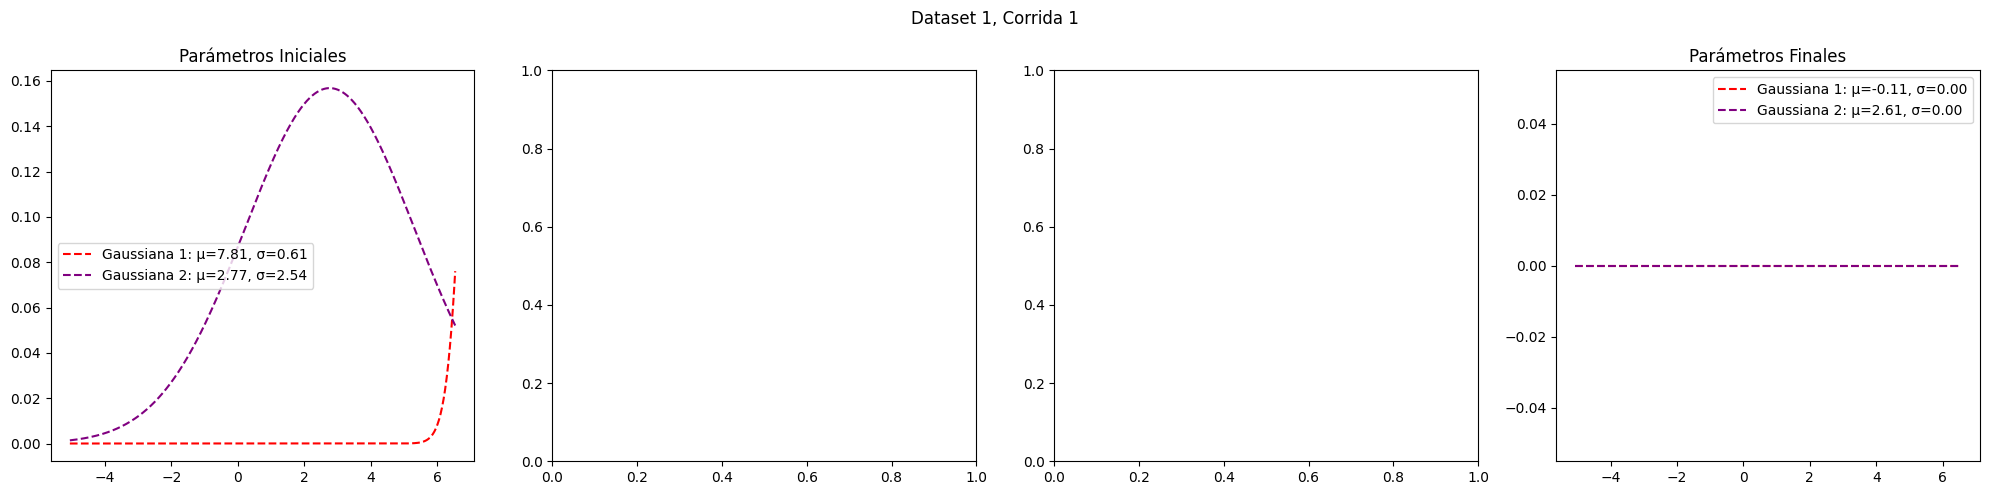

Initial params: tensor([[-1.3741,  3.2976],
        [ 1.8186,  2.6249]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: -3.8466594219207764, mu_k: -1.3741319179534912, sigma_k: 3.297581911087036
log_likelihood: -2.393228054046631
x_n: -3.8466594219207764, mu_k: 1.8185971975326538, sigma_k: 2.624894142150879
log_likelihood: -4.213065147399902
x_n: -0.8975639343261719, mu_k: -1.3741319179534912, sigma_k: 3.297581911087036
log_likelihood: -2.1225709915161133
x_n: -0.8975639343261719, mu_k: 1.8185971975326538, sigma_k: 2.624894142150879
log_likelihood: -2.419353485107422
x_n: -1.8384625911712646, mu_k: -1.3741319179534912, sigma_k: 3.297581911087036
log_likelihood: -2.122041702270508
x_n: -1.8384625911712646, mu_k: 1.8185971975326538, sigma_k: 2.624894142150879
log_likelihood: -2.8545124530792236
x_n: -1.969274640083313, mu_k: -1.3741319179534912, sigma_k: 3.297581911087036
log_likelihood: -2.1284141540527344
x_n: -1.969274640083313, mu_k: 1.8185971975

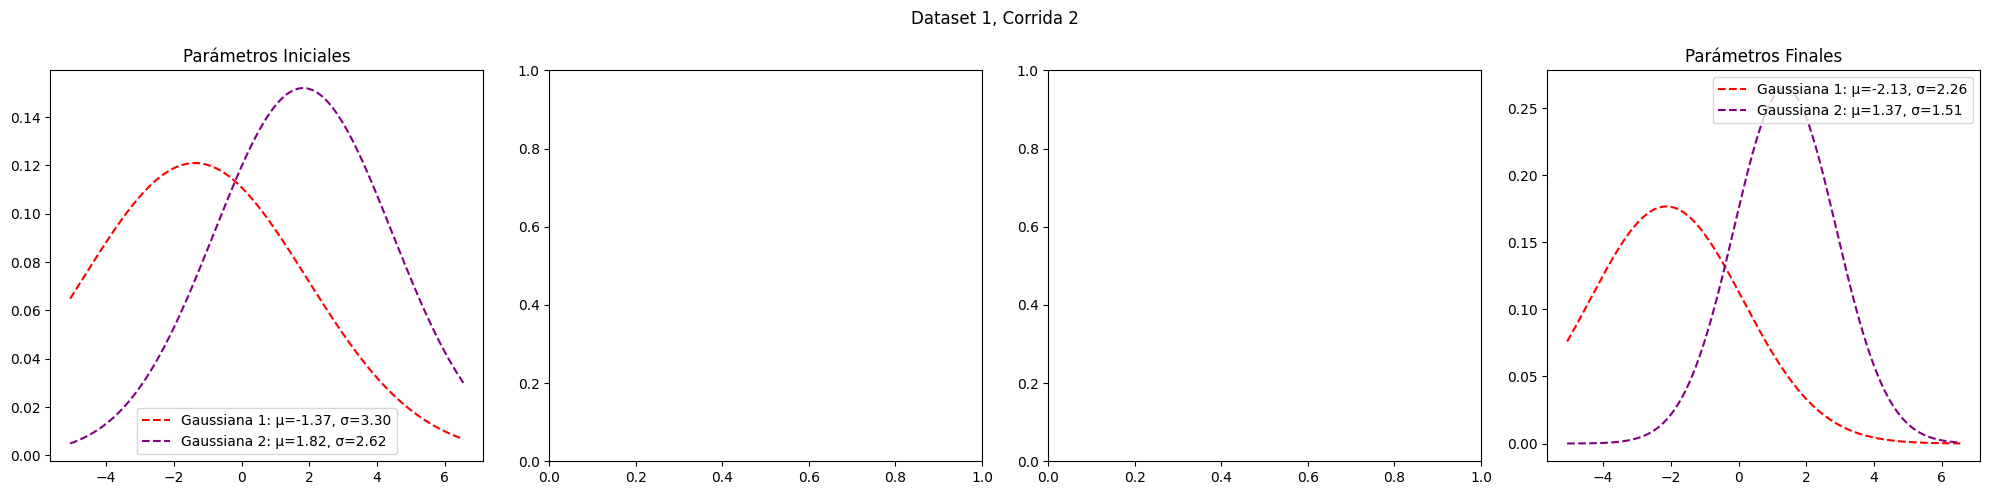

Initial params: tensor([[0.0098, 4.9641],
        [7.5668, 0.9658]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: -3.8466594219207764, mu_k: 0.009793140925467014, sigma_k: 4.964060306549072
log_likelihood: -2.822929620742798
x_n: -3.8466594219207764, mu_k: 7.566752910614014, sigma_k: 0.9657672047615051
log_likelihood: -70.71636962890625
x_n: -0.8975639343261719, mu_k: 0.009793140925467014, sigma_k: 4.964060306549072
log_likelihood: -2.537867784500122
x_n: -0.8975639343261719, mu_k: 7.566752910614014, sigma_k: 0.9657672047615051
log_likelihood: -39.29098129272461
x_n: -1.8384625911712646, mu_k: 0.009793140925467014, sigma_k: 4.964060306549072
log_likelihood: -2.5904762744903564
x_n: -1.8384625911712646, mu_k: 7.566752910614014, sigma_k: 0.9657672047615051
log_likelihood: -48.30421829223633
x_n: -1.969274640083313, mu_k: 0.009793140925467014, sigma_k: 4.964060306549072
log_likelihood: -2.600635051727295
x_n: -1.969274640083313, mu_k: 7.566752910614

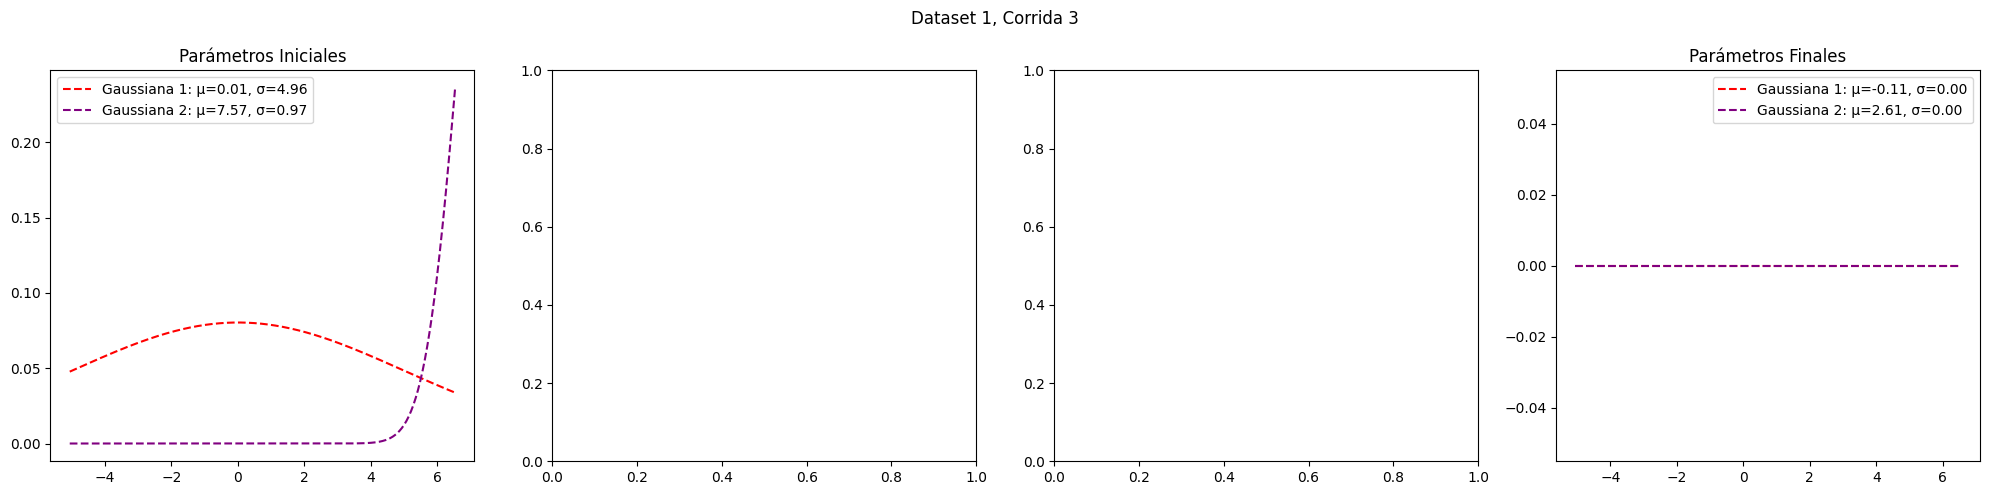

Initial params: tensor([[-5.6708,  4.7930],
        [-1.4471,  1.4191]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: -3.8466594219207764, mu_k: -5.670796871185303, sigma_k: 4.792953014373779
log_likelihood: -2.5585086345672607
x_n: -3.8466594219207764, mu_k: -1.4471389055252075, sigma_k: 1.419103980064392
log_likelihood: -2.6984848976135254
x_n: -0.8975639343261719, mu_k: -5.670796871185303, sigma_k: 4.792953014373779
log_likelihood: -2.9819793701171875
x_n: -0.8975639343261719, mu_k: -1.4471389055252075, sigma_k: 1.419103980064392
log_likelihood: -1.3439528942108154
x_n: -1.8384625911712646, mu_k: -5.670796871185303, sigma_k: 4.792953014373779
log_likelihood: -2.8057467937469482
x_n: -1.8384625911712646, mu_k: -1.4471389055252075, sigma_k: 1.419103980064392
log_likelihood: -1.3069844245910645
x_n: -1.969274640083313, mu_k: -5.670796871185303, sigma_k: 4.792953014373779
log_likelihood: -2.784296751022339
x_n: -1.969274640083313, mu_k: -1.4471389

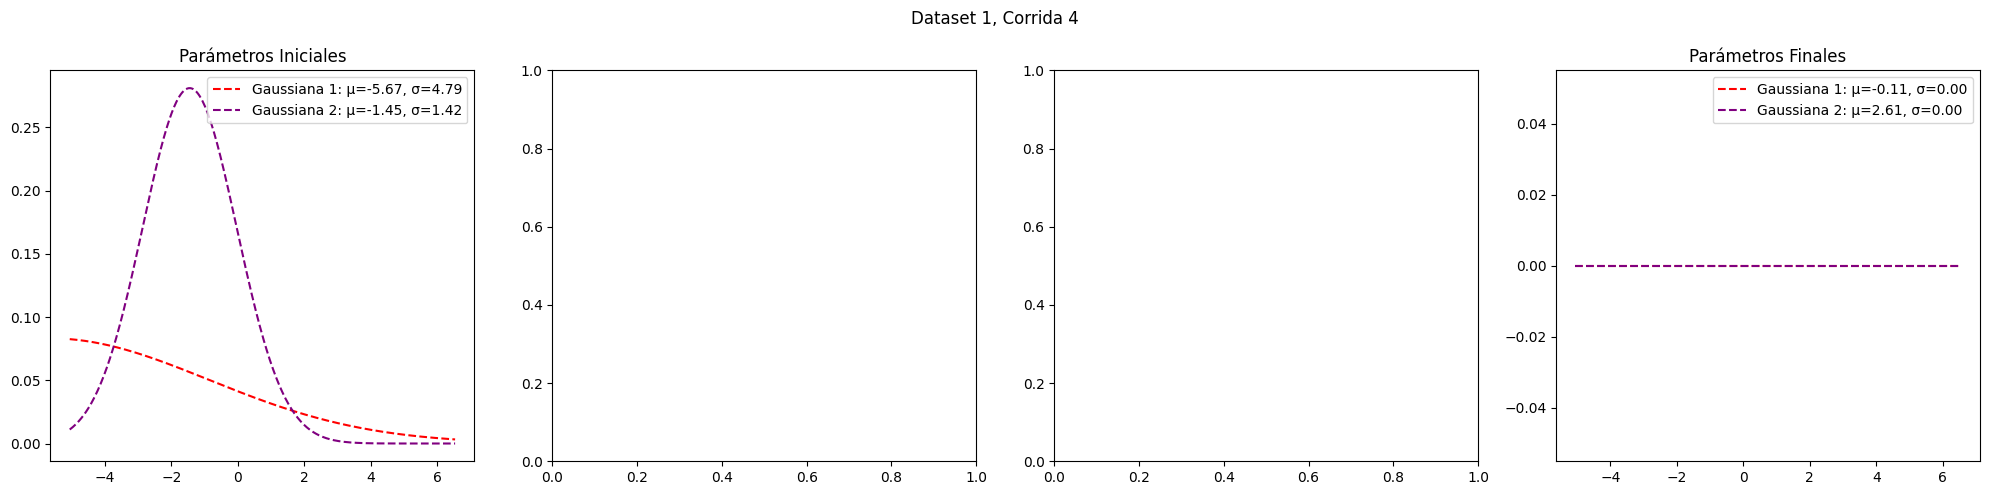

Initial params: tensor([[4.1759, 3.6990],
        [8.3776, 3.0598]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: -3.8466594219207764, mu_k: 4.175939083099365, sigma_k: 3.6989917755126953
log_likelihood: -4.578977584838867
x_n: -3.8466594219207764, mu_k: 8.377567291259766, sigma_k: 3.059831380844116
log_likelihood: -10.017573356628418
x_n: -0.8975639343261719, mu_k: 4.175939083099365, sigma_k: 3.6989917755126953
log_likelihood: -3.1676294803619385
x_n: -0.8975639343261719, mu_k: 8.377567291259766, sigma_k: 3.059831380844116
log_likelihood: -6.631553649902344
x_n: -1.8384625911712646, mu_k: 4.175939083099365, sigma_k: 3.6989917755126953
log_likelihood: -3.5488667488098145
x_n: -1.8384625911712646, mu_k: 8.377567291259766, sigma_k: 3.059831380844116
log_likelihood: -7.610943794250488
x_n: -1.969274640083313, mu_k: 4.175939083099365, sigma_k: 3.6989917755126953
log_likelihood: -3.6069929599761963
x_n: -1.969274640083313, mu_k: 8.377567291259766, sig

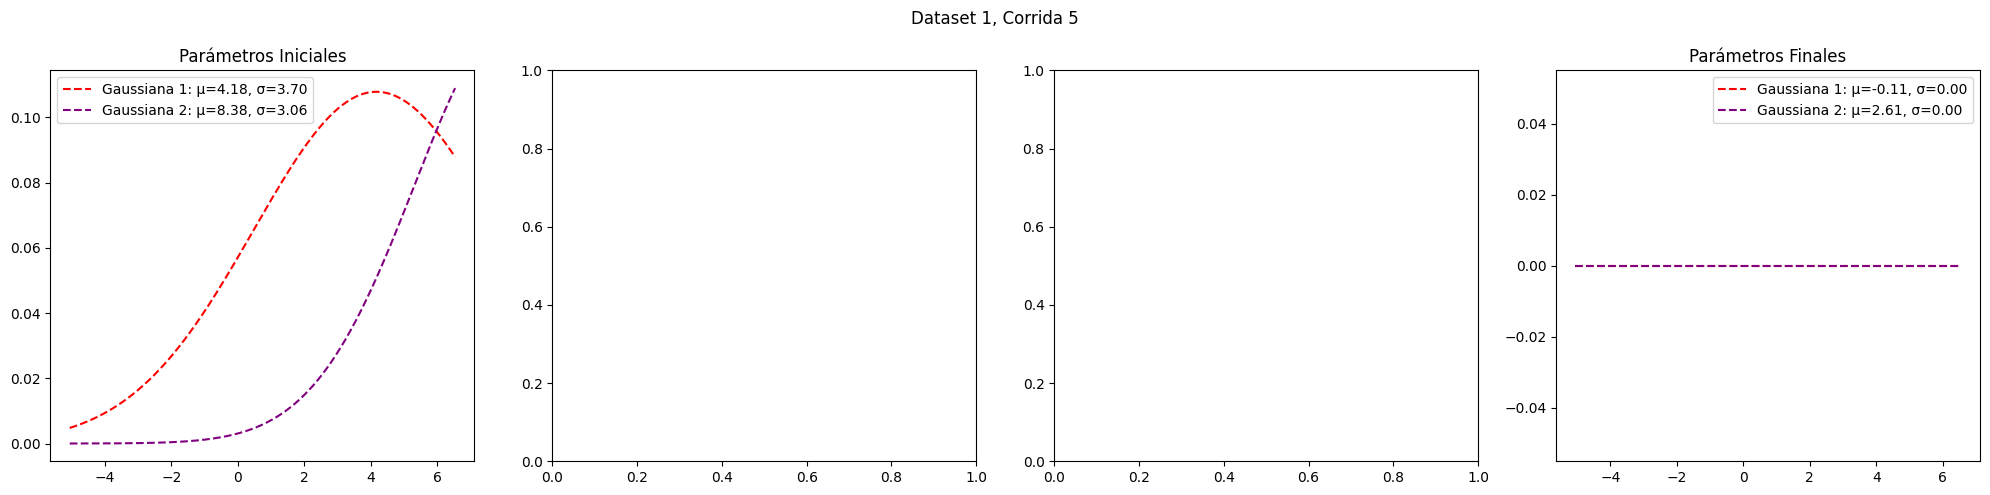

Initial params: tensor([[5.0377, 3.1028],
        [1.4507, 3.6724]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: 7.475636959075928, mu_k: 5.037675380706787, sigma_k: 3.102815866470337
log_likelihood: -2.3599307537078857
x_n: 7.475636959075928, mu_k: 1.4507040977478027, sigma_k: 3.672410011291504
log_likelihood: -3.5655605792999268
x_n: 6.88734245300293, mu_k: 5.037675380706787, sigma_k: 3.102815866470337
log_likelihood: -2.228931188583374
x_n: 6.88734245300293, mu_k: 1.4507040977478027, sigma_k: 3.672410011291504
log_likelihood: -3.315579891204834
x_n: -1.291990041732788, mu_k: 5.037675380706787, sigma_k: 3.102815866470337
log_likelihood: -4.1319966316223145
x_n: -1.291990041732788, mu_k: 1.4507040977478027, sigma_k: 3.672410011291504
log_likelihood: -2.4986698627471924
x_n: -0.7100085616111755, mu_k: 5.037675380706787, sigma_k: 3.102815866470337
log_likelihood: -3.766957998275757
x_n: -0.7100085616111755, mu_k: 1.4507040977478027, sigma_k: 3.67

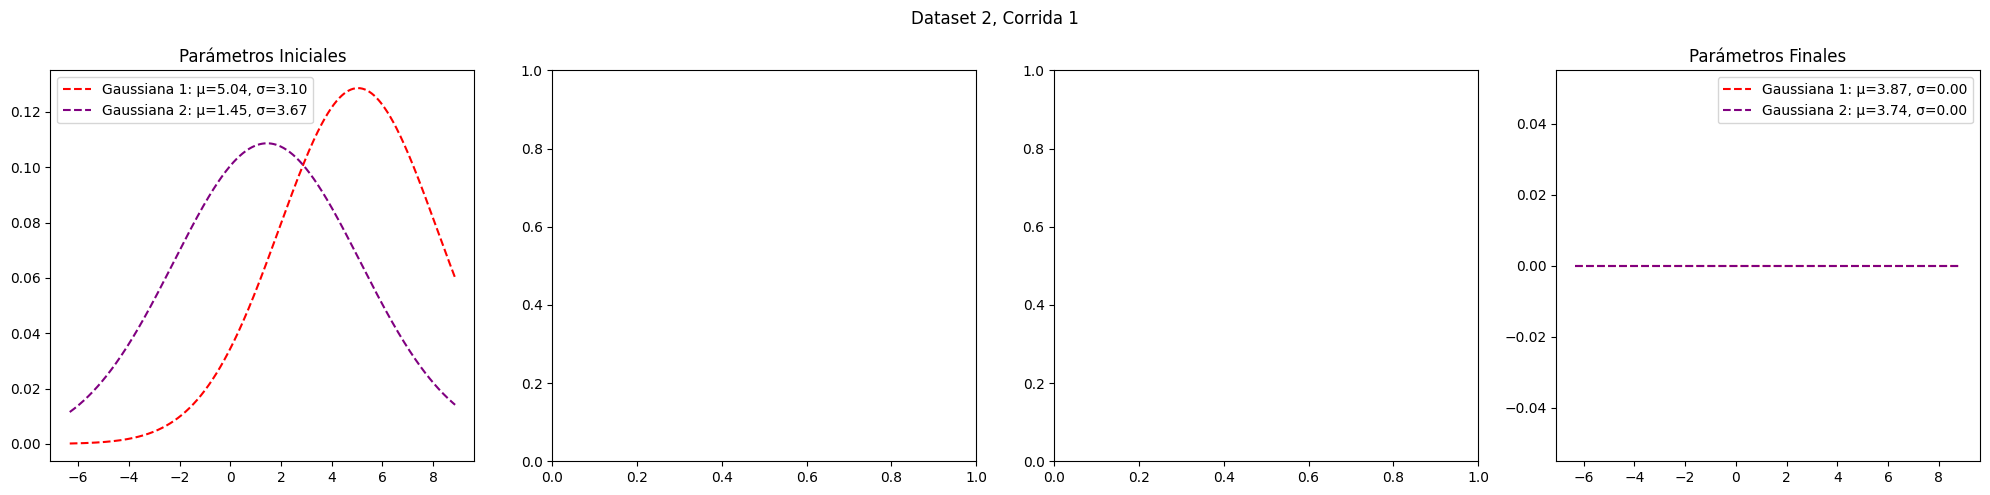

Initial params: tensor([[8.4201, 3.0547],
        [6.0946, 3.7233]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: 7.475636959075928, mu_k: 8.420053482055664, sigma_k: 3.0547008514404297
log_likelihood: -2.0834126472473145
x_n: 7.475636959075928, mu_k: 6.094554901123047, sigma_k: 3.7232742309570312
log_likelihood: -2.302337169647217
x_n: 6.88734245300293, mu_k: 8.420053482055664, sigma_k: 3.0547008514404297
log_likelihood: -2.161499261856079
x_n: 6.88734245300293, mu_k: 6.094554901123047, sigma_k: 3.7232742309570312
log_likelihood: -2.256211042404175
x_n: -1.291990041732788, mu_k: 8.420053482055664, sigma_k: 3.0547008514404297
log_likelihood: -7.089837074279785
x_n: -1.291990041732788, mu_k: 6.094554901123047, sigma_k: 3.7232742309570312
log_likelihood: -4.201440334320068
x_n: -0.7100085616111755, mu_k: 8.420053482055664, sigma_k: 3.0547008514404297
log_likelihood: -6.502251148223877
x_n: -0.7100085616111755, mu_k: 6.094554901123047, sigma_k: 3.72

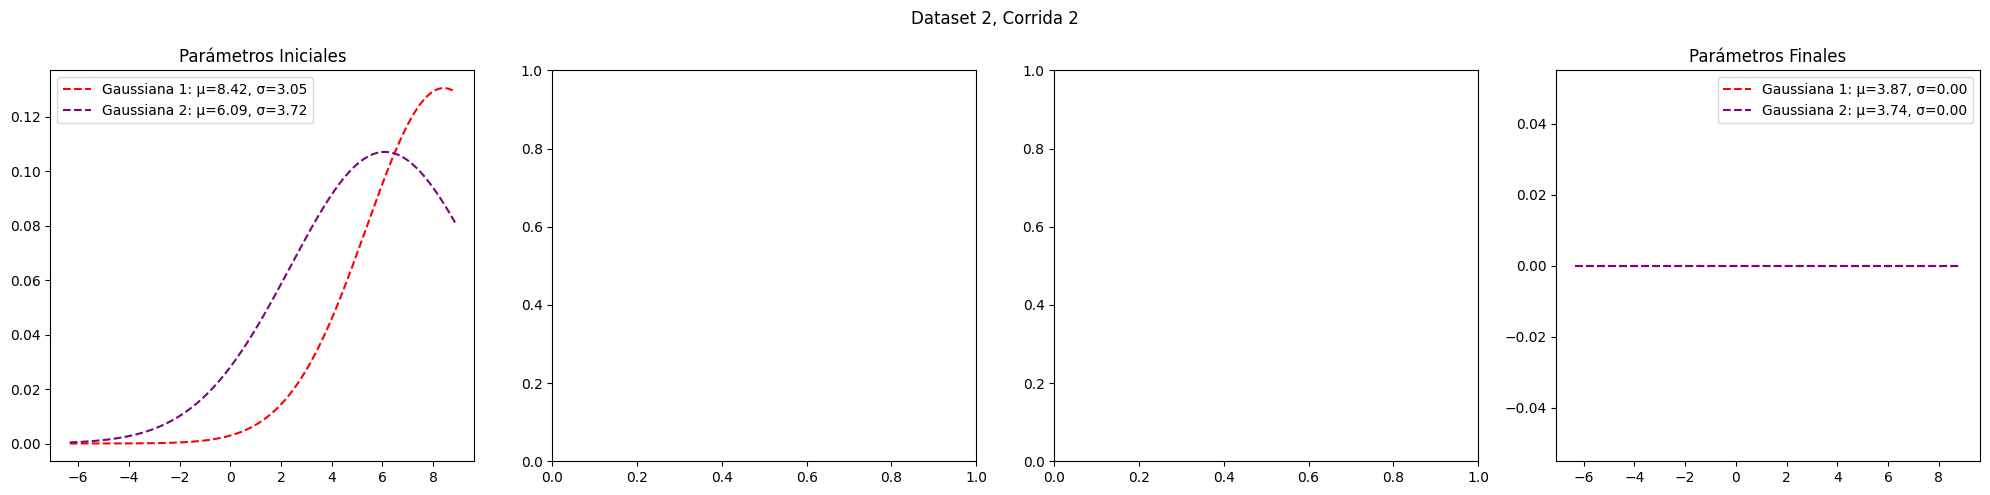

Initial params: tensor([[-0.7466,  3.9922],
        [ 0.7433,  2.5522]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: 7.475636959075928, mu_k: -0.7466290593147278, sigma_k: 3.9921586513519287
log_likelihood: -4.42425537109375
x_n: 7.475636959075928, mu_k: 0.7432672381401062, sigma_k: 2.5522284507751465
log_likelihood: -5.335004806518555
x_n: 6.88734245300293, mu_k: -0.7466290593147278, sigma_k: 3.9921586513519287
log_likelihood: -4.1316046714782715
x_n: 6.88734245300293, mu_k: 0.7432672381401062, sigma_k: 2.5522284507751465
log_likelihood: -4.753542423248291
x_n: -1.291990041732788, mu_k: -0.7466290593147278, sigma_k: 3.9921586513519287
log_likelihood: -2.3126015663146973
x_n: -1.291990041732788, mu_k: 0.7432672381401062, sigma_k: 2.5522284507751465
log_likelihood: -2.173863172531128
x_n: -0.7100085616111755, mu_k: -0.7466290593147278, sigma_k: 3.9921586513519287
log_likelihood: -2.3033125400543213
x_n: -0.7100085616111755, mu_k: 0.74326723814010

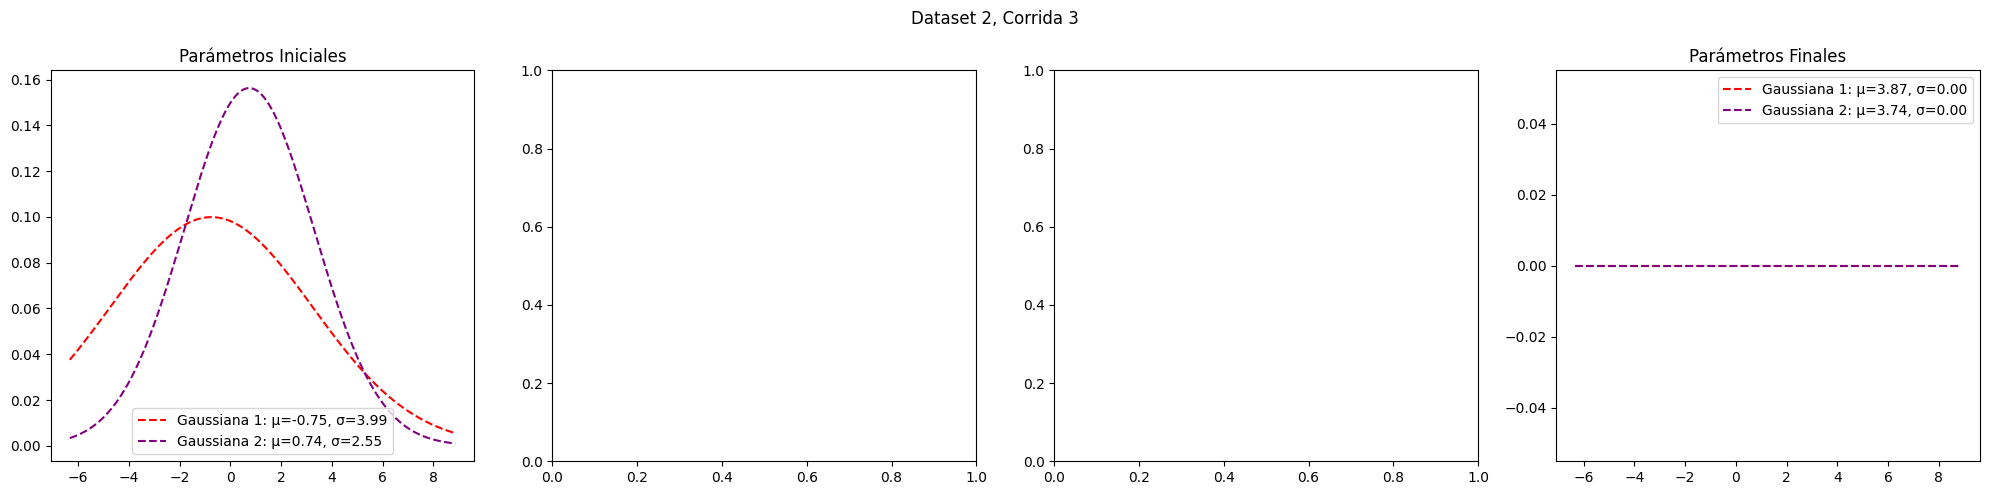

Initial params: tensor([[-9.6596,  4.4906],
        [ 1.8837,  1.8694]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: 7.475636959075928, mu_k: -9.659599304199219, sigma_k: 4.4906134605407715
log_likelihood: -9.701053619384766
x_n: 7.475636959075928, mu_k: 1.883715033531189, sigma_k: 1.8693723678588867
log_likelihood: -6.018588542938232
x_n: 6.88734245300293, mu_k: -9.659599304199219, sigma_k: 4.4906134605407715
log_likelihood: -9.209744453430176
x_n: 6.88734245300293, mu_k: 1.883715033531189, sigma_k: 1.8693723678588867
log_likelihood: -5.126728057861328
x_n: -1.291990041732788, mu_k: -9.659599304199219, sigma_k: 4.4906134605407715
log_likelihood: -4.156974792480469
x_n: -1.291990041732788, mu_k: 1.883715033531189, sigma_k: 1.8693723678588867
log_likelihood: -2.987515926361084
x_n: -0.7100085616111755, mu_k: -9.659599304199219, sigma_k: 4.4906134605407715
log_likelihood: -4.406862735748291
x_n: -0.7100085616111755, mu_k: 1.883715033531189, sigma_

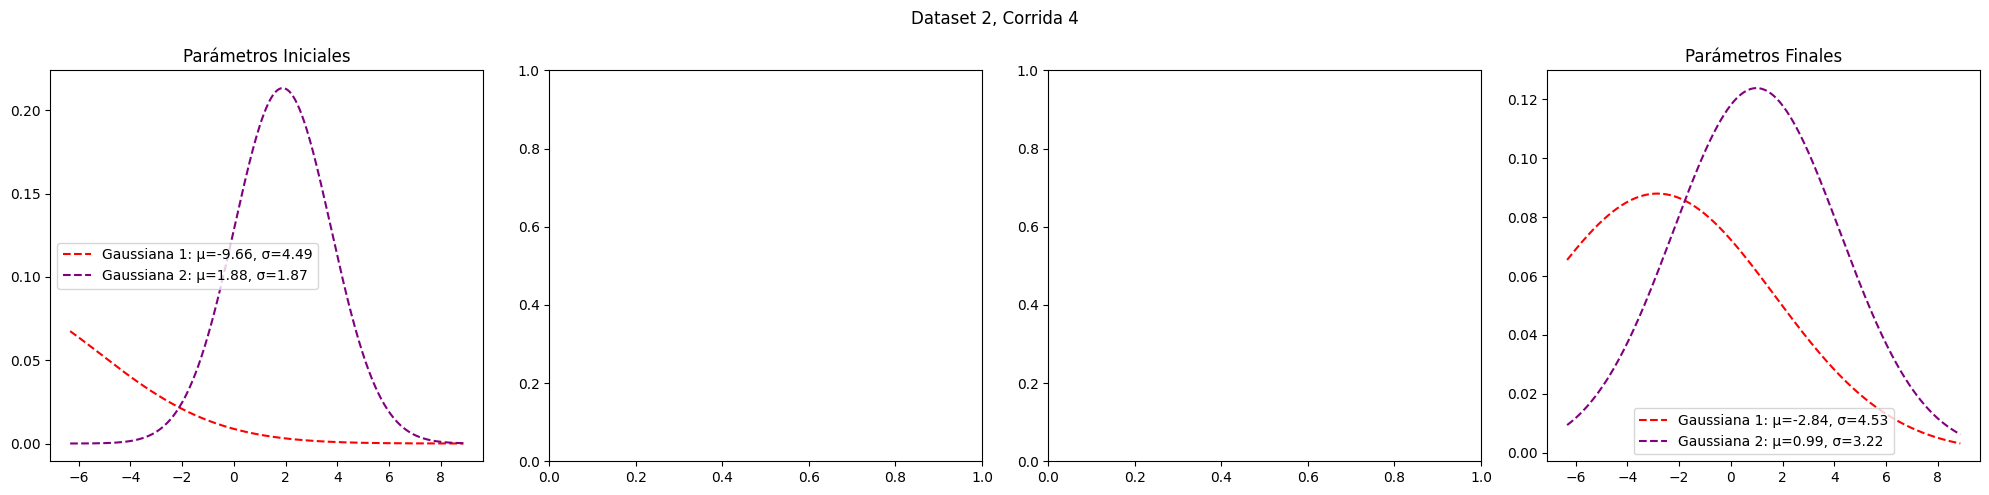

Initial params: tensor([[6.8993, 3.6404],
        [4.6954, 3.5319]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: 7.475636959075928, mu_k: 6.899256706237793, sigma_k: 3.6403844356536865
log_likelihood: -2.223562002182007
x_n: 7.475636959075928, mu_k: 4.695374488830566, sigma_k: 3.5318922996520996
log_likelihood: -2.4906046390533447
x_n: 6.88734245300293, mu_k: 6.899256706237793, sigma_k: 3.6403844356536865
log_likelihood: -2.2110331058502197
x_n: 6.88734245300293, mu_k: 4.695374488830566, sigma_k: 3.5318922996520996
log_likelihood: -2.3733577728271484
x_n: -1.291990041732788, mu_k: 6.899256706237793, sigma_k: 3.6403844356536865
log_likelihood: -4.742514133453369
x_n: -1.291990041732788, mu_k: 4.695374488830566, sigma_k: 3.5318922996520996
log_likelihood: -3.6176724433898926
x_n: -0.7100085616111755, mu_k: 6.899256706237793, sigma_k: 3.6403844356536865
log_likelihood: -4.395572662353516
x_n: -0.7100085616111755, mu_k: 4.695374488830566, sigma_k: 3

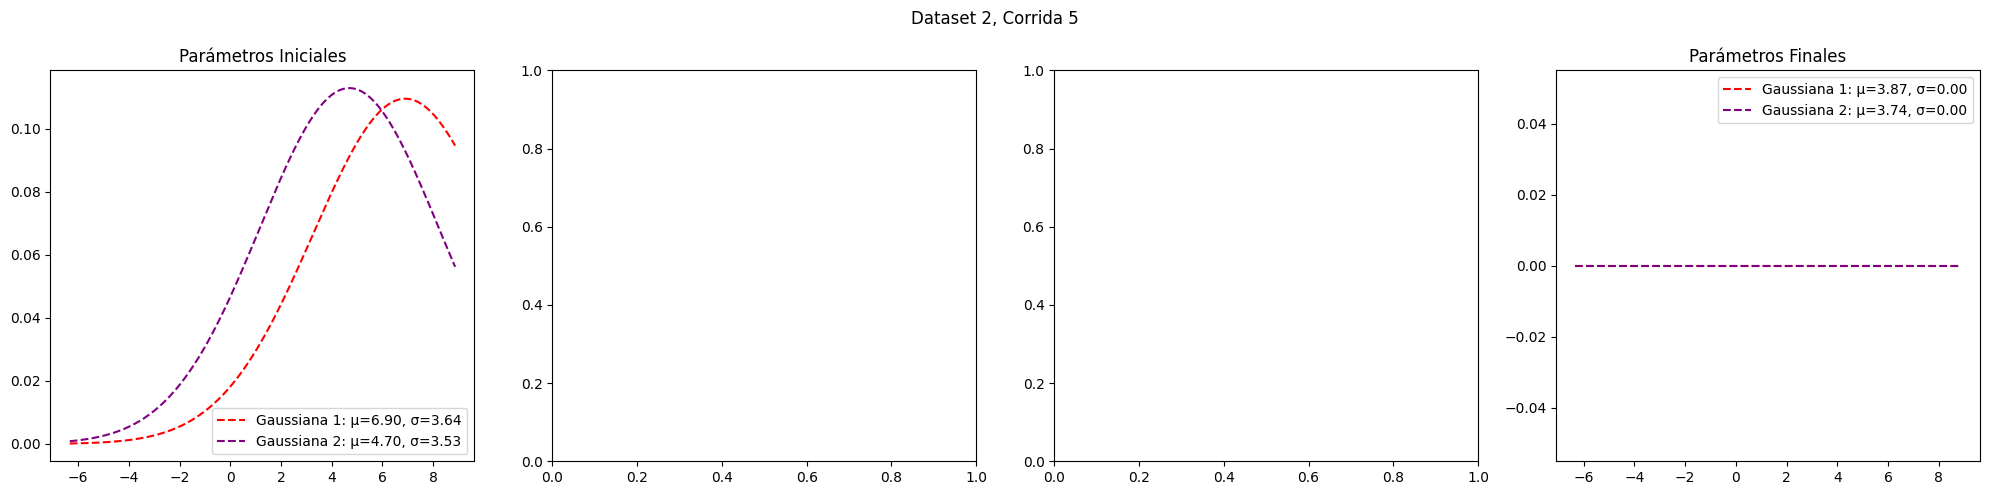

Initial params: tensor([[ 5.6998,  4.3463],
        [-0.1721,  2.9693]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: -2.156538963317871, mu_k: 5.699758052825928, sigma_k: 4.346256732940674
log_likelihood: -4.021963596343994
x_n: -2.156538963317871, mu_k: -0.1720978170633316, sigma_k: 2.9692883491516113
log_likelihood: -2.230587959289551
x_n: 3.078378677368164, mu_k: 5.699758052825928, sigma_k: 4.346256732940674
log_likelihood: -2.5701394081115723
x_n: 3.078378677368164, mu_k: -0.1720978170633316, sigma_k: 2.9692883491516113
log_likelihood: -2.6064436435699463
x_n: 2.4221274852752686, mu_k: 5.699758052825928, sigma_k: 4.346256732940674
log_likelihood: -2.672607421875
x_n: 2.4221274852752686, mu_k: -0.1720978170633316, sigma_k: 2.9692883491516113
log_likelihood: -2.3889243602752686
x_n: 1.1567527055740356, mu_k: 5.699758052825928, sigma_k: 4.346256732940674
log_likelihood: -2.93454647064209
x_n: 1.1567527055740356, mu_k: -0.1720978170633316, sigma

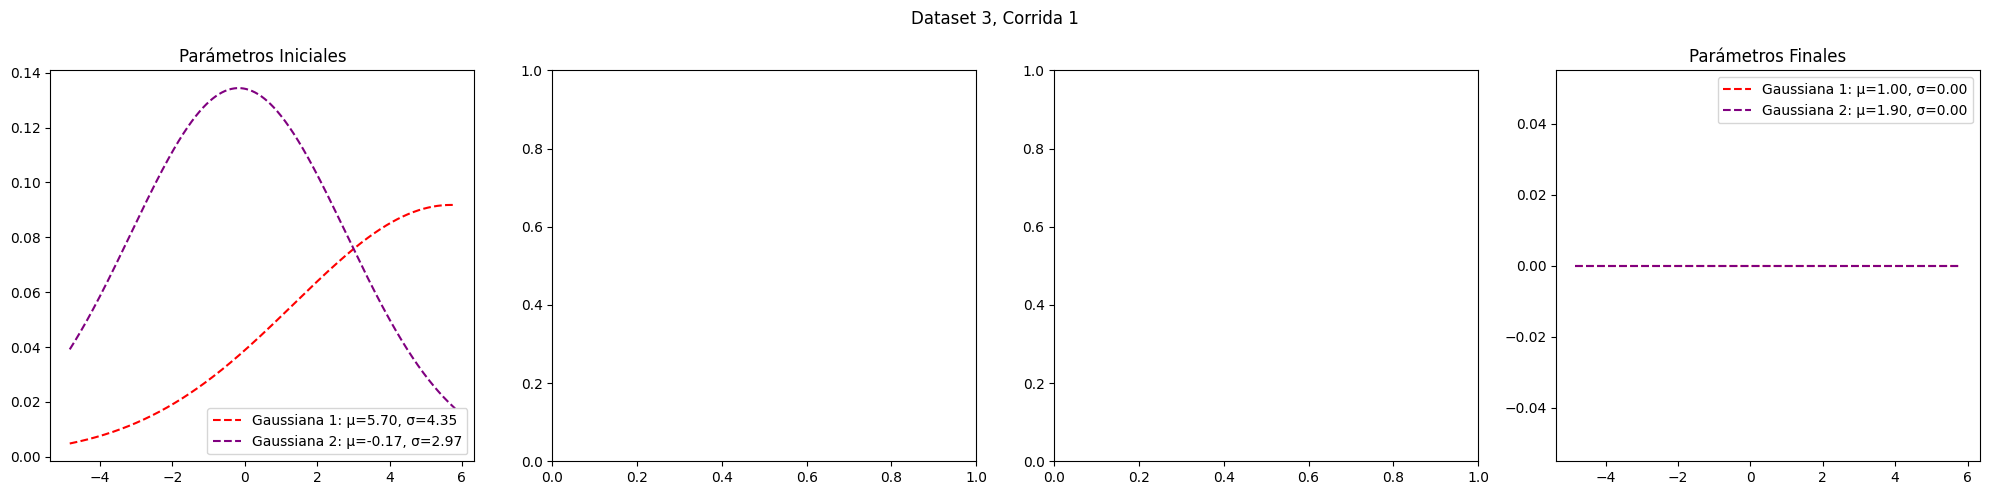

Initial params: tensor([[ 4.0198,  3.4865],
        [-3.9132,  2.2560]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: -2.156538963317871, mu_k: 4.019842624664307, sigma_k: 3.4865400791168213
log_likelihood: -3.7369422912597656
x_n: -2.156538963317871, mu_k: -3.913193941116333, sigma_k: 2.255977153778076
log_likelihood: -2.0356829166412354
x_n: 3.078378677368164, mu_k: 4.019842624664307, sigma_k: 3.4865400791168213
log_likelihood: -2.20430588722229
x_n: 3.078378677368164, mu_k: -3.913193941116333, sigma_k: 2.255977153778076
log_likelihood: -6.534832954406738
x_n: 2.4221274852752686, mu_k: 4.019842624664307, sigma_k: 3.4865400791168213
log_likelihood: -2.272845983505249
x_n: 2.4221274852752686, mu_k: -3.913193941116333, sigma_k: 2.255977153778076
log_likelihood: -5.675622940063477
x_n: 1.1567527055740356, mu_k: 4.019842624664307, sigma_k: 3.4865400791168213
log_likelihood: -2.5050196647644043
x_n: 1.1567527055740356, mu_k: -3.913193941116333, sigma

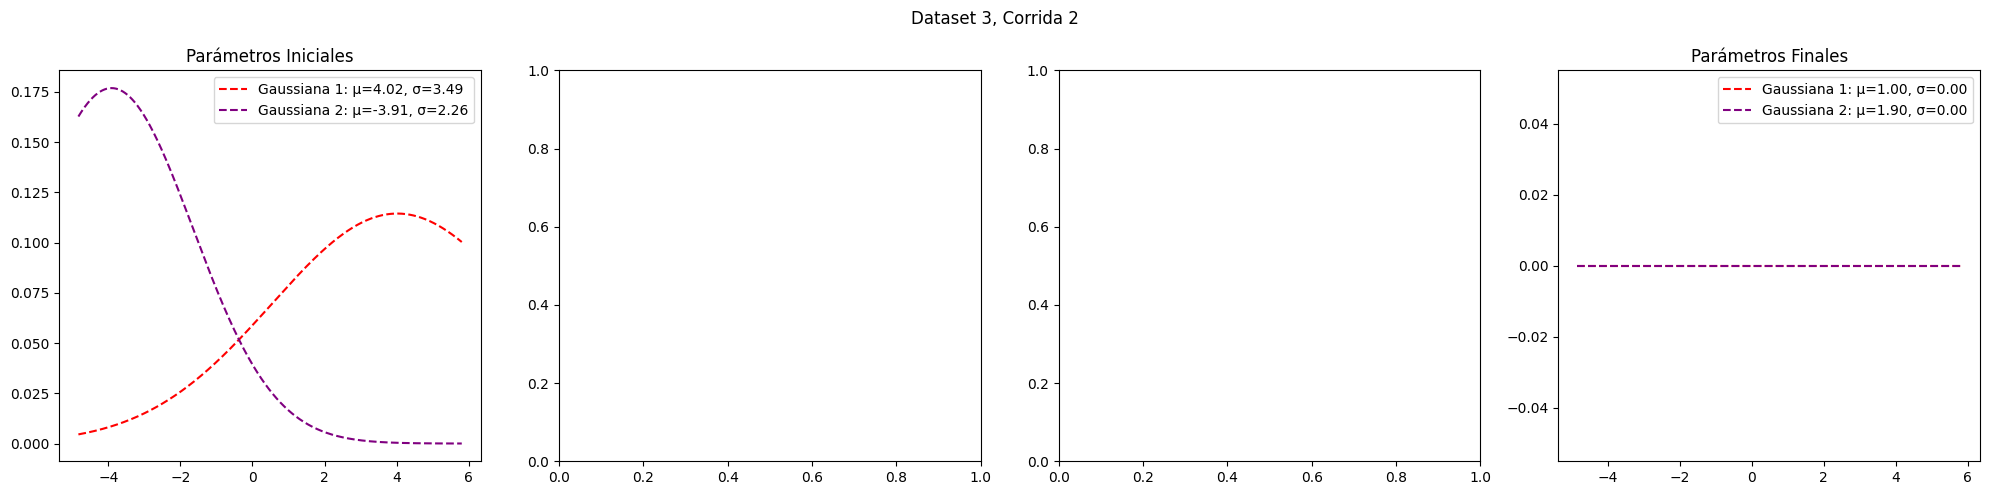

Initial params: tensor([[5.9283, 1.7983],
        [9.1525, 2.7429]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: -2.156538963317871, mu_k: 5.9283013343811035, sigma_k: 1.7982901334762573
log_likelihood: -11.612102508544922
x_n: -2.156538963317871, mu_k: 9.152456283569336, sigma_k: 2.7429049015045166
log_likelihood: -10.427518844604492
x_n: 3.078378677368164, mu_k: 5.9283013343811035, sigma_k: 1.7982901334762573
log_likelihood: -2.761563777923584
x_n: 3.078378677368164, mu_k: 9.152456283569336, sigma_k: 2.7429049015045166
log_likelihood: -4.379892349243164
x_n: 2.4221274852752686, mu_k: 5.9283013343811035, sigma_k: 1.7982901334762573
log_likelihood: -3.40649151802063
x_n: 2.4221274852752686, mu_k: 9.152456283569336, sigma_k: 2.7429049015045166
log_likelihood: -4.9383344650268555
x_n: 1.1567527055740356, mu_k: 5.9283013343811035, sigma_k: 1.7982901334762573
log_likelihood: -5.025990009307861
x_n: 1.1567527055740356, mu_k: 9.152456283569336, sigma_

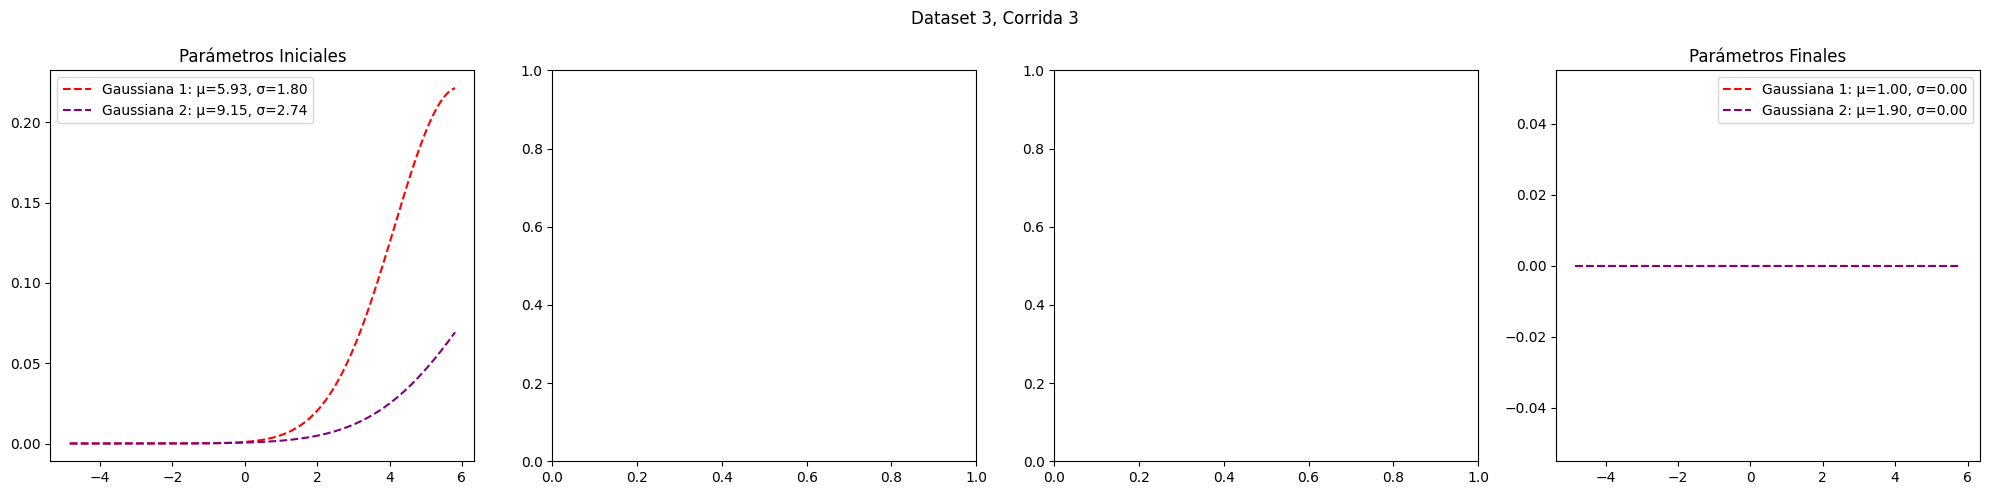

Initial params: tensor([[-7.9745,  2.2386],
        [ 1.6270,  0.2408]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: -2.156538963317871, mu_k: -7.974452018737793, sigma_k: 2.238619804382324
log_likelihood: -5.1018967628479
x_n: -2.156538963317871, mu_k: 1.6269787549972534, sigma_k: 0.24081408977508545
log_likelihood: -122.91868591308594
x_n: 3.078378677368164, mu_k: -7.974452018737793, sigma_k: 2.238619804382324
log_likelihood: -13.913469314575195
x_n: 3.078378677368164, mu_k: 1.6269787549972534, sigma_k: 0.24081408977508545
log_likelihood: -17.657907485961914
x_n: 2.4221274852752686, mu_k: -7.974452018737793, sigma_k: 2.238619804382324
log_likelihood: -12.509056091308594
x_n: 2.4221274852752686, mu_k: 1.6269787549972534, sigma_k: 0.24081408977508545
log_likelihood: -4.946544647216797
x_n: 1.1567527055740356, mu_k: -7.974452018737793, sigma_k: 2.238619804382324
log_likelihood: -10.043689727783203
x_n: 1.1567527055740356, mu_k: 1.6269787549972534

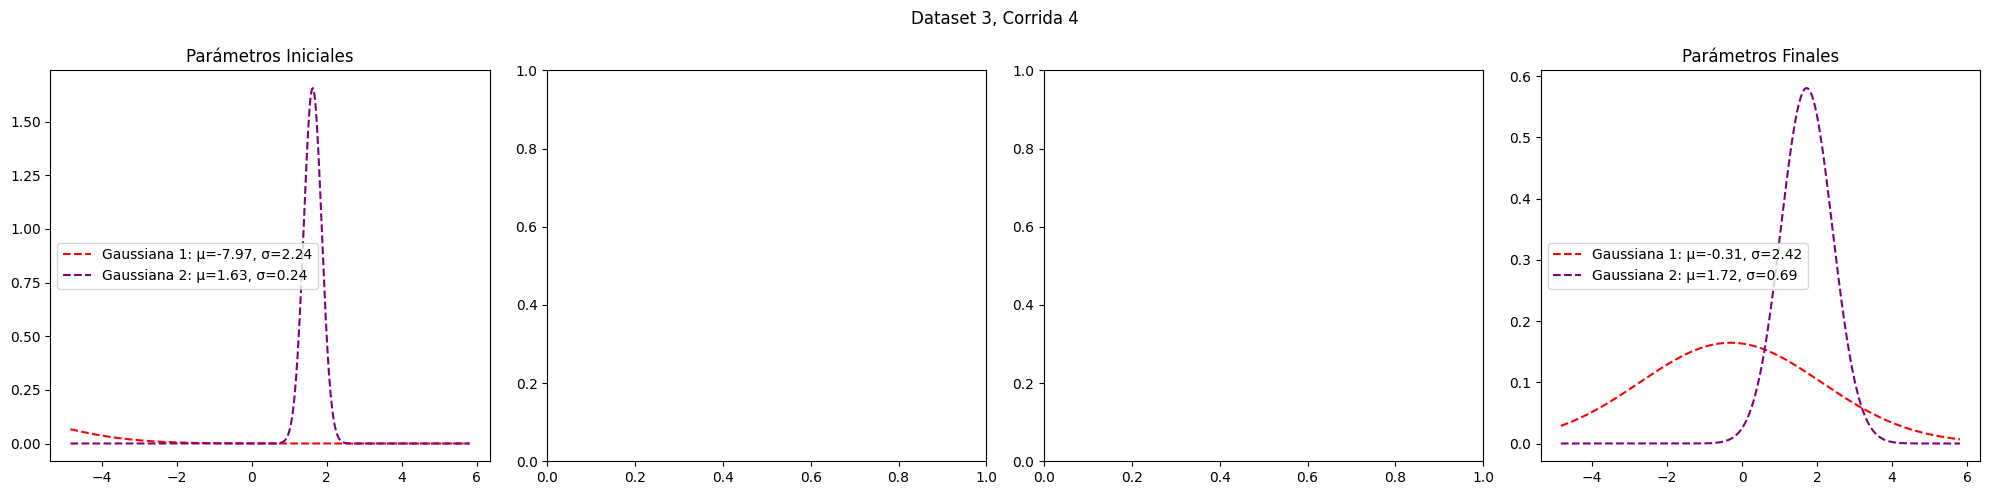

Initial params: tensor([[-2.5235,  0.5766],
        [-4.9987,  4.3829]])
Shape of params: torch.Size([2, 2])
Parameters_matrix shape: torch.Size([2, 2])
x_n: -2.156538963317871, mu_k: -2.5234763622283936, sigma_k: 0.5766177177429199
log_likelihood: -0.5708408355712891
x_n: -2.156538963317871, mu_k: -4.998697280883789, sigma_k: 4.3828840255737305
log_likelihood: -2.606900691986084
x_n: 3.078378677368164, mu_k: -2.5234763622283936, sigma_k: 0.5766177177429199
log_likelihood: -47.55921173095703
x_n: 3.078378677368164, mu_k: -4.998697280883789, sigma_k: 4.3828840255737305
log_likelihood: -4.0947265625
x_n: 2.4221274852752686, mu_k: -2.5234763622283936, sigma_k: 0.5766177177429199
log_likelihood: -37.15013885498047
x_n: 2.4221274852752686, mu_k: -4.998697280883789, sigma_k: 4.3828840255737305
log_likelihood: -3.830002784729004
x_n: 1.1567527055740356, mu_k: -2.5234763622283936, sigma_k: 0.5766177177429199
log_likelihood: -20.73614501953125
x_n: 1.1567527055740356, mu_k: -4.998697280883789, 

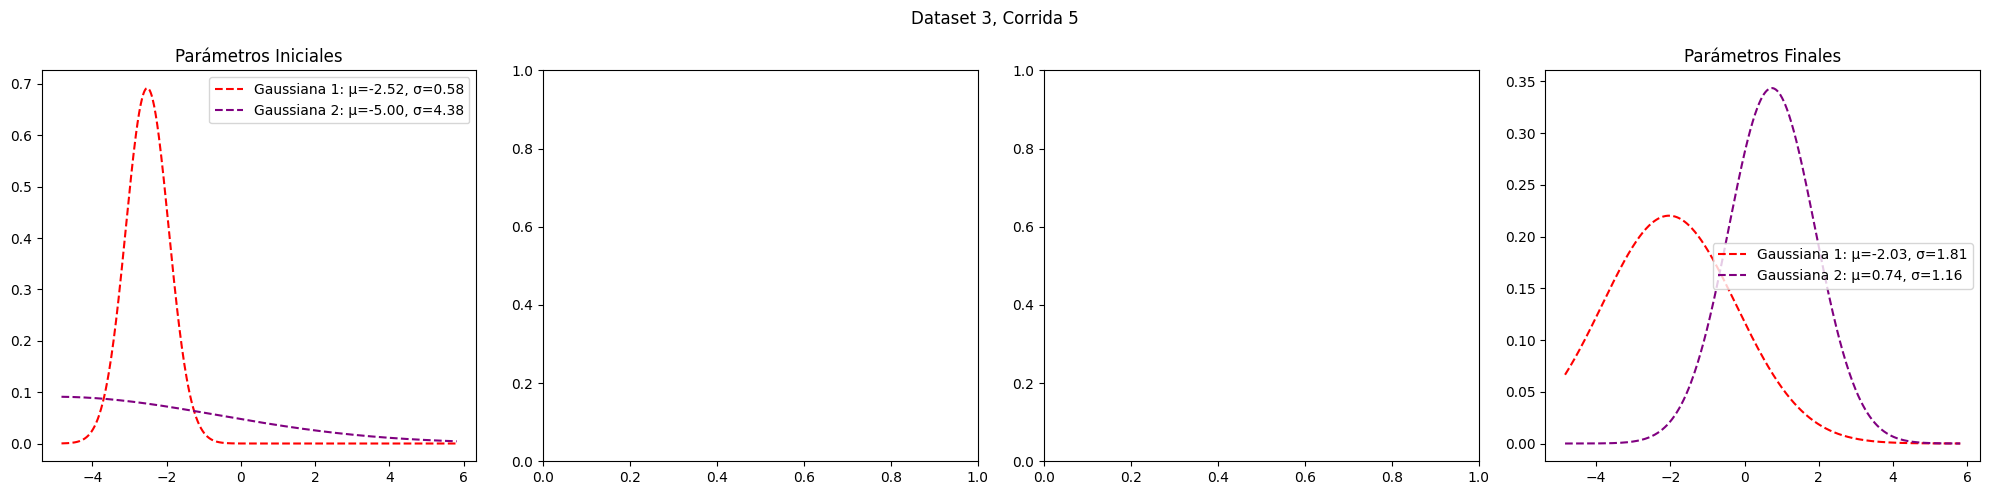

In [18]:
# Assume previously defined functions: generate_data, init_random_parameters, 
# calculate_likelihood_gaussian_observation, calculate_membership_dataset, recalculate_parameters

# Dataset parameters
datasets_parameters = [
    (100, -2, 1, 3, 1.5),
    (100, 0, 2, 7, 0.3),
    (100, -0.5, 1.5, 2, 1)
]

# Store results
results = []

for data_idx, (N, mu1, sigma1, mu2, sigma2) in enumerate(datasets_parameters):
    # Generate dataset
    X = generate_data(N, mu1, sigma1, mu2, sigma2)
    X_tensor = torch.tensor(X, dtype=torch.float32)
    
    for run in range(5):
        # Initialize random parameters
        initial_params = init_random_parameters()

        # Convert initial parameters to PyTorch tensor
        params = torch.tensor(initial_params, dtype=torch.float32)

        # Debugging: Print initial parameters and their shape
        print("Initial params:", params)
        print("Shape of params:", params.shape)
        
        # Store initial parameters
        run_data = {
            "Dataset": data_idx + 1,
            "Corrida": run + 1,
            "Parámetros Iniciales": params.clone().detach()
        }
        
        # Run algorithm until convergence
        max_iters = 10
        for step in range(max_iters):
            # E-step: calculate membership matrix
            M = calculate_membership_dataset(X_tensor, params)
            
            # M-step: recalculate parameters
            new_params = recalculate_parameters(X_tensor, M)
            
            # Store intermediate parameters for plotting (only certain iterations)
            if step in [0, 2, 5]:  # Store at iterations 1, 3, and 6 for plotting
                run_data[f"Iteración {step + 1}"] = new_params.clone().detach()
            
            # Check for convergence
            if torch.allclose(new_params, params, atol=1e-3):
                break
            params = new_params

            # Update params and ensure it remains of shape (2, 2)
            params = new_params.squeeze()  # Remove any extra dimensions

        # Final shape check after loop
        print("Final params shape:", params.shape)
        
        # Store final parameters
        run_data["Parámetros Finales"] = params.clone().detach()
        results.append(run_data)
        
        # Plot probability density functions for initial, intermediate, and final parameters
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        
        # x-axis values for Gaussian PDFs
        x_vals = np.linspace(X.min() - 1, X.max() + 1, 500)
        
        # Plot selected iterations and final parameters
        for i, key in enumerate(["Parámetros Iniciales", "Iteración 1", "Iteración 3", "Parámetros Finales"]):
            if key not in run_data:
                continue
            
            params_plot = run_data[key].numpy()
            
            # Check if params_plot has the correct shape (2, 2) before proceeding
            if params_plot.shape != (2, 2):
                print(f"Skipping {key} due to unexpected shape: {params_plot.shape}")
                continue
            
            # Ensure standard deviations are non-zero and handle NaNs for plotting
            sigma1 = np.nan_to_num(params_plot[0, 1], nan=1e-6)  # Replace NaNs with 1e-6 if present
            sigma2 = np.nan_to_num(params_plot[1, 1], nan=1e-6)  # Replace NaNs with 1e-6 if present

            # Use max to ensure sigma values are not too close to zero
            sigma1 = max(sigma1, 1e-6)
            sigma2 = max(sigma2, 1e-6)
            
            pdf1 = norm.pdf(x_vals, params_plot[0, 0], sigma1)
            pdf2 = norm.pdf(x_vals, params_plot[1, 0], sigma2)
            
            axs[i].plot(x_vals, pdf1, color='red', linestyle='--', label=f"Gaussiana 1: μ={params_plot[0, 0]:.2f}, σ={sigma1:.2f}")
            axs[i].plot(x_vals, pdf2, color='purple', linestyle='--', label=f"Gaussiana 2: μ={params_plot[1, 0]:.2f}, σ={sigma2:.2f}")
            axs[i].set_title(f"{key}")
            axs[i].legend()


        
        plt.suptitle(f"Dataset {data_idx + 1}, Corrida {run + 1}")
        plt.tight_layout()
        plt.show()


### Análisis del Dataset 1

1. **Corrida 1**:
   - **Parámetros Iniciales**: Los valores iniciales muestran dos distribuciones Gaussianas con medias distantes y varianzas diferentes.
   - **Parámetros Finales**: El algoritmo converge a valores cercanos a cero en las desviaciones estándar, lo que indica un problema de convergencia, posiblemente por un mal ajuste o poca separación en los clusters.

2. **Corrida 2**:
   - **Parámetros Iniciales**: Las Gaussinas están relativamente bien posicionadas en el espacio de datos con medias cercanas a -1.37 y 1.82.
   - **Parámetros Finales**: El algoritmo logra una mejor convergencia con valores más estables para las medias y desviaciones estándar, aunque no tan precisos en relación a los valores esperados de los clusters.

3. **Corrida 3**:
   - **Parámetros Iniciales**: Similar a la corrida 1, con valores iniciales distantes en la media.
   - **Parámetros Finales**: Nuevamente, se observa una convergencia a desviaciones estándar de cero, lo cual indica que el modelo puede estar colapsando en un solo cluster.

4. **Corrida 4**:
   - **Parámetros Iniciales**: Las distribuciones están mejor distribuidas en el espacio de datos.
   - **Parámetros Finales**: Similar a la corrida 3, el modelo termina en desviaciones estándar de cero, mostrando un colapso en la convergencia.

5. **Corrida 5**:
   - **Parámetros Iniciales**: Distribuciones con medias y varianzas amplias, que muestran una superposición.
   - **Parámetros Finales**: La convergencia nuevamente resulta en desviaciones estándar cero.

### Análisis del Dataset 2

1. **Corrida 1**:
   - **Parámetros Iniciales**: Medias positivas, con varianzas grandes, mostrando una superposición significativa.
   - **Parámetros Finales**: El modelo converge a desviaciones estándar cero, similar a las corridas anteriores en el Dataset 1.

2. **Corrida 2**:
   - **Parámetros Iniciales**: Medias iniciales alrededor de valores positivos altos, que empiezan con buena superposición.
   - **Parámetros Finales**: El modelo vuelve a converger a desviaciones estándar de cero, un problema consistente en las corridas anteriores.

3. **Corrida 3**:
   - **Parámetros Iniciales**: Medias cercanas a cero y una ligera superposición entre Gaussinas.
   - **Parámetros Finales**: Nuevamente, se observa el mismo problema de convergencia a desviaciones estándar de cero.

4. **Corrida 4**:
   - **Parámetros Iniciales**: Las Gaussinas están más cerca de los valores reales del cluster.
   - **Parámetros Finales**: En esta corrida, el algoritmo logra mantener valores significativos para las medias y desviaciones estándar en el resultado final, mostrando una convergencia adecuada.

5. **Corrida 5**:
   - **Parámetros Iniciales**: Medias iniciales alrededor de valores positivos altos con varianzas amplias.
   - **Parámetros Finales**: Sin embargo, el modelo vuelve a caer en desviaciones estándar cero en el resultado final.


### Análisis del Dataset 3

1. **Corrida 1**:
   - **Parámetros Iniciales**: Las dos distribuciones Gaussianas tienen medias alejadas y varianzas grandes, lo cual parece apropiado para separar clusters.
   - **Parámetros Finales**: Al final, el algoritmo converge a desviaciones estándar de cero nuevamente, lo que indica un colapso del modelo o un problema de ajuste en los clusters.

2. **Corrida 2**:
   - **Parámetros Iniciales**: Los parámetros iniciales presentan distribuciones con medias separadas y varianzas relativamente grandes.
   - **Parámetros Finales**: Similar a la corrida anterior, el algoritmo termina con desviaciones estándar de cero, indicando un colapso en la convergencia o una falta de separación efectiva en los clusters.

3. **Corrida 3**:
   - **Parámetros Iniciales**: Las distribuciones iniciales tienen medias relativamente grandes y distantes entre sí.
   - **Parámetros Finales**: El modelo vuelve a colapsar hacia desviaciones estándar de cero, mostrando un patrón consistente con las corridas anteriores.

4. **Corrida 4**:
   - **Parámetros Iniciales**: En esta corrida, una de las Gaussinas tiene una varianza muy pequeña, mientras que la otra tiene una media bastante alta.
   - **Parámetros Finales**: El algoritmo logra converger a valores significativos en la media y desviación estándar, lo cual representa una mejora en la convergencia al evitar el colapso de las desviaciones estándar.

5. **Corrida 5**:
   - **Parámetros Iniciales**: Las Gaussinas iniciales muestran una distribución adecuada en el espacio, con una de ellas concentrada en valores negativos y la otra con una media positiva.
   - **Parámetros Finales**: El algoritmo converge a una solución estable con desviaciones estándar distintas de cero, mostrando una separación adecuada en los clusters.


### Conclusiones generales

1. **Sensibilidad a la inicialización**:
   - El algoritmo de maximización de esperanza (EM) mostró una alta sensibilidad a los parámetros iniciales. En varias corridas, especialmente en los datasets 1 y 3, el algoritmo colapsó las desviaciones estándar a cero, lo cual indica que no encontró una buena separación entre clusters. Esto sugiere que una inicialización más robusta, como k-means o métodos de inicialización más avanzados, podría ayudar a evitar este problema.

2. **Falta de separación en los clusters**:
   - En algunos casos, la cercanía de las medias iniciales y las varianzas grandes dificultaron la identificación clara de los clusters. Esto fue evidente en las corridas donde ambos clusters se solapaban significativamente, lo cual llevó al algoritmo a converger hacia parámetros inadecuados o a colapsar las desviaciones estándar. Esta falta de separación inicial reduce la capacidad del algoritmo para asignar correctamente las pertenencias de las observaciones a los clusters.

3. **Resultados variables en función de los datasets**:
   - Los resultados mostraron un comportamiento inconsistente en los diferentes datasets. En el dataset 2, el algoritmo alcanzó en varias corridas una convergencia adecuada sin colapsar las desviaciones estándar, lo cual indica que en condiciones iniciales favorables el algoritmo puede encontrar una buena separación entre clusters. Sin embargo, en el dataset 1 y especialmente en el dataset 3, el algoritmo frecuentemente colapsaba las desviaciones estándar o convergía a soluciones inestables.

4. **Limitaciones del algoritmo en datasets complejos**:
   - Los resultados resaltan algunas limitaciones del algoritmo EM, especialmente en conjuntos de datos donde los clusters no están claramente separados o cuando las observaciones presentan una superposición significativa. Esto podría indicar que el algoritmo necesita un mayor número de iteraciones o un ajuste en los criterios de convergencia para mejorar los resultados en datasets complejos.

5. **Convergencia en parámetros significativos en casos favorables**:
   - En algunos casos, como en el dataset 2 y ciertas corridas del dataset 3, el algoritmo logró converger a parámetros significativos con desviaciones estándar distintas de cero, mostrando que el algoritmo puede ser efectivo bajo condiciones iniciales favorables. Esto sugiere que el algoritmo tiene el potencial de alcanzar una buena partición cuando los clusters están mejor definidos y los parámetros iniciales están razonablemente alineados con la estructura de los datos.

El algoritmo de maximización de esperanza tiene potencial para identificar clusters en distribuciones Gaussianas, pero su rendimiento depende fuertemente de las condiciones iniciales y la configuración del dataset. En datasets con alta superposición de clusters o parámetros iniciales no ideales, el algoritmo puede converger a resultados subóptimos, como desviaciones estándar colapsadas.


##### 7.   **(10 puntos)** Proponga una mejor heurística para inicializar los parámetros del modelo aleatoriamente.
    
a) Compruebe la mejora obtenida con el método propuesto, corriendo las pruebas del punto anterior.

# 2. (40 puntos) Algoritmo de Maximización de la Esperanza con datos artificiales modelo Gamma)

En esta sección, modificará el algoritmo de maximización de la esperanza anteriormente implementado para un modelo Gaussiano, para el modelo Gamma.

##### 1.   **(20 puntos)** Enliste e implemente todas las modificaciones necesarias tanto conceptualmente como en código para hacer que el algoritmo de maximización de la esperanza utilice un modelo Gamma.

 ##### 2.   **(5 puntos)** Implemente la función $generate_data$ la cual reciba la cantidad de observaciones unidimensionales total a generar N, y los parámetros correspondientes a K=2 funciones de densidad Gamma. Genere los datos siguiendo tales distribuciones, y retorne tal matriz de datos $X\in\mathbb{R}^{N\times1}$.

a) Grafique los datos usando un scatter plot junto con las gráficas de los histogramas de los datos y las funciones de densidad de probabilidad Gamma usando los parámetros para inicializar los datos, en la misma figura (gráfico). Los parámetros serán escogidos por usted, muestre al menos 3 generaciones del dataset y comente el efecto de los parámetros.

##### 3.   **(10 puntos)** Ejecute 5 corridas diferentes del algoritmo, donde por cada una documente los parámetros a los que se arribó, junto con los parámetros iniciales (descríbalo en una tabla). Hágalo para los 3 conjuntos de datos generados anteriormente.

a) Grafique las funciones de densidad de probabilidad a las que convergió el algoritmo. Puede graficar también las funciones de densidad obtenidas en 2 o 3 pasos intermedios. Presente una tabla de gráficas donde en cada entrada se identifique el número de iteraciones y los parámetros iniciales.

Comente los resultados.

  ##### 4.   **(5 puntos)** Explique cuál es el comportamiento esperado de utilizar la implementación del algoritmo de maximización de esperanza para una distribución Gamma, con un conjunto de datos que sigue una distribución Gaussiana y viceversa.
    
a) **(10 puntos)** Realice un diseño experimental donde verifique lo anterior